Development for The Dataland election predictions

Figure test.png saved in reports directory.


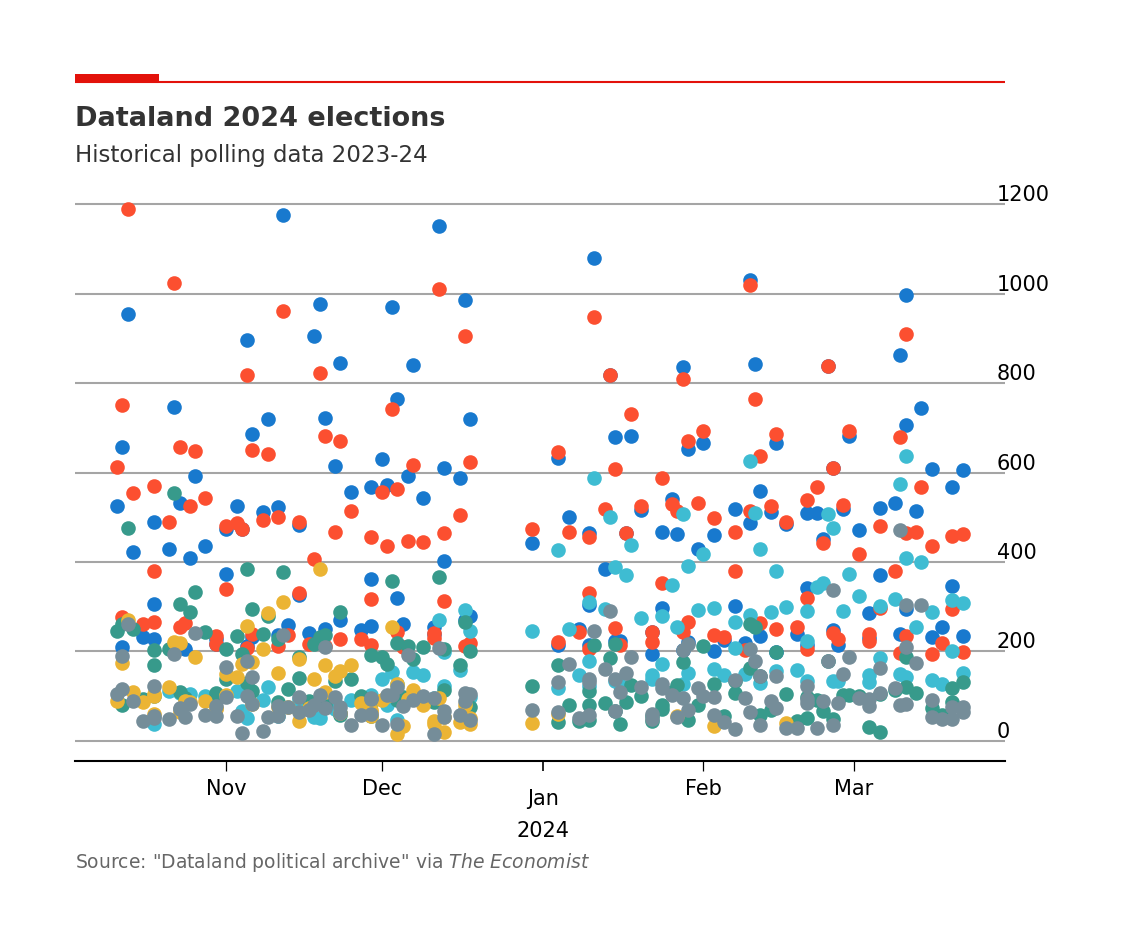

In [1]:
import sys
sys.path.append('..')

from src import DataEngineering, PlotTimeSeries
from matplotlib import pyplot as plt
import numpy as np

df = DataEngineering().load_from_file()
plt_ts = PlotTimeSeries()
fig, ax = plt_ts.get_panels()

for i in ['Bulstrode', 'Lydgate', 'Vincy', 'Casaubon', 'Chettam', 'Others']:

    ax.scatter(df['Date'], df[i] * df['Sample'])
    


plt_ts.set_title('Dataland 2024 elections', subtitle='Historical polling data 2023-24')
plt_ts.set_source('Dataland political archive', pad=0.15)

# fig.set_facecolor('lightgrey')
plt_ts.savefig('test.png', dpi=250)

          Date          Pollster      Sample  Bulstrode   Lydgate   Vincy  \
0   2023-10-12  Bardi University  683.000000   0.307000  0.405000     NaN   
1   2023-10-13               NaN  687.333333   0.309167  0.400167     NaN   
2   2023-10-14               NaN  691.666667   0.311333  0.395333     NaN   
3   2023-10-15               NaN  696.000000   0.313500  0.390500     NaN   
4   2023-10-16               NaN  700.333333   0.315667  0.385667     NaN   
..         ...               ...         ...        ...       ...     ...   
158 2024-03-18               NaN  655.333333   0.355000  0.298667  0.2160   
159 2024-03-19               NaN  656.500000   0.355000  0.299000  0.2195   
160 2024-03-20               NaN  657.666667   0.355000  0.299333  0.2230   
161 2024-03-21               NaN  658.833333   0.355000  0.299667  0.2265   
162 2024-03-22  Bardi University  660.000000   0.355000  0.300000  0.2300   

     Casaubon  Chettam  Others Excludes overseas candidates  
0       0.117

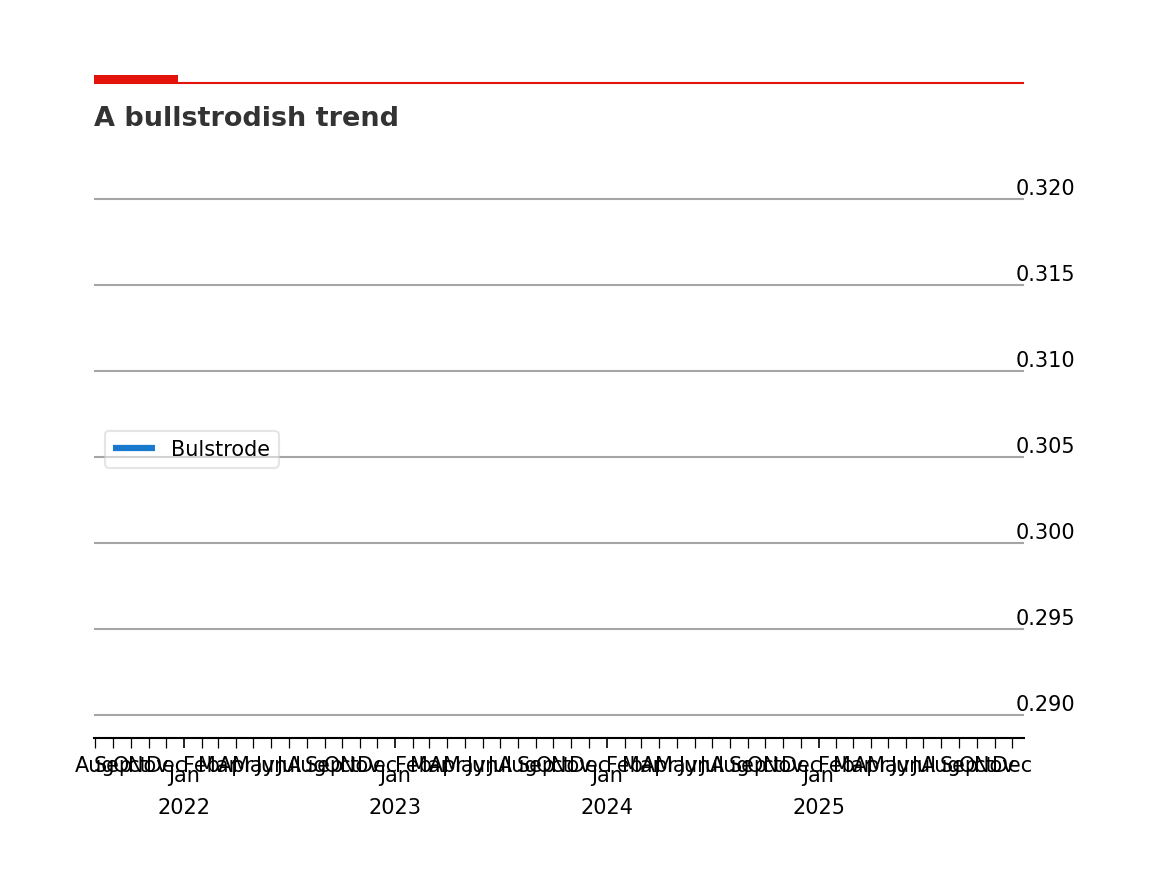

In [68]:
from src import DataScience

df = DataEngineering().load_from_file()
ds = DataScience(df)
pollsters = ds.load_pollsters_list_from_file()
plt_ts = PlotTimeSeries()
fig, ax = plt_ts.get_panels()

polling_averages = {}
polling_trends = {}

for territory in ['Bulstrode']:#, 'Lydgate', 'Vincy', 'Casaubon', 'Chettam', 'Others']:

    df_p = ds.load_pollster_from_file(pollsters[0])
    print(df_p)
    weighted_average = df_p[territory].fillna(value=0) * df_p['Sample'].fillna(value=0)
    total_samples = df_p['Sample'].fillna(value=0)
    

    for pollster in pollsters[1:]:
        df_p = ds.load_pollster_from_file(pollster)
        
        weighted_average += df_p[territory].fillna(value=0) * df_p['Sample'].fillna(value=0)
        total_samples += df_p['Sample'].fillna(value=0)

    weighted_average /= total_samples

    # Determing rolling statistics
    weekly_average = weighted_average.rolling(window=7, win_type='gaussian').mean(std=3)
    limit = min(len(df_p['Date']), len(weighted_average), len(weekly_average))
    
    polling_averages['Date'] = df_p['Date'][:limit]
    polling_trends['Date'] = df_p['Date'][:limit]
    polling_averages[territory] = weighted_average.values[:limit]
    polling_trends[territory] = weekly_average.values[:limit]

    ax.plot(df_p['Date'][:limit], weighted_average[:limit], label=territory) 
#     ax.plot(df_p['Date'][:limit], weekly_average[:limit])
    
ax.legend(fontsize=10, loc='center left', frameon=True, framealpha=0.5)
plt_ts.set_title('A bullstrodish trend')

In [ ]:
# plt.scatter(df_p['Sample'], df_p['Bulstrode'])
plt.scatter(df_p['Bulstrode'], df_p['Casaubon'])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
# df_p.set_index('Date', inplace=True)
result = seasonal_decompose(df_p['Bulstrode'], period=30, model='additive', two_sided=False, extrapolate_trend=0)
result.plot()

In [ ]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

df_p['Bulstrode'].hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(df_p['Bulstrode'], lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = df_p['Bulstrode'].rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = df_p['Bulstrode'].rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

# Forefasting

In [ ]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2024-03-01'
df_training = df_p.loc[df_p.index <= split_date]
df_test = df_p.loc[df_p.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

In [ ]:
# ARMA example
from tqdm.auto import tqdm
from src.feature_engineering import evaluate
import pandas as pd
import pmdarima as pm

#adding exogenous variable
df_p['weekday_index'] = df_p.index.weekday
['Bulstrode', 'Lydgate', 'Vincy', 'Casaubon', 'Chettam', 'Others']
# SARIMAX Model
SARIMAX_model = pm.auto_arima(df_p[['Lydgate']], exogenous=df_p[['Sample']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                              
                           stepwise=True)

def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame(
        {"weekday_index": pd.date_range(df_p.index[-1], periods = n_periods, freq='D').month},
        index = pd.date_range(df_p.index[-1] + pd.DateOffset(days=1), 
                              periods = n_periods, 
                              freq='D')
    )

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['weekday_index']])
    index_of_fc = pd.date_range(df_p.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    print(fitted_series)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_p["Lydgate"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

election_day = np.datetime64('2024-10-10') 
n_days_to_election = (election_day - df_p.index.max()).days
    
sarimax_forecast(SARIMAX_model, periods=n_days_to_election)

# Pure sklearn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:

df_p